# Data Science 1, Winter Semester 2021/22
---
# Exercise Sheet 2: Classification

Let's load the dataset and add the target `species` as a new column.
This is the same procedure as for the first exercise sheet.

In [1]:
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Series(iris.target, name='species').replace({i: name for i, name in enumerate(iris.target_names)})
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## a) Training

Creating and training prediction models with `sklearn` is easy.

First, we create an object for the prediction model.
There is a separate class for each model type.
During creation, we can set model-specific hyperparameters.
Here, we leave the hyperparameters at their defaults, but set a random state.
This guarantees that the trained tree always is the same if we execute this code block multiple times.
(See `sklearn`'s documentation to find out how decision-tree training might be non-deterministic.)
After creating the object, you can still use `set_params()` to modify its hyperparameters.

Second, we call the `fit()` method, which exists for all model types.
For supervised algorithms, it gets the feature values `X` and the target variable `y` as parameters.
For unsupervised algorithms, it only gets `X`, as we will see when solving the fourth exercise sheet.

In [2]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=25)
decision_tree.fit(X=iris_df.drop(columns='species'), y=iris_df['species'])
decision_tree

DecisionTreeClassifier(random_state=25)

Okay, printing the tree object does not really give us useful information about the trained model, but that's why we have the next subtask.
We can see the values of all hyperparameters with method `get_params()`:

In [3]:
decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 25,
 'splitter': 'best'}

By default, these hyperparameters don't limit tree growth.
For example, depth is unlimited and there might be only one sample in each leaf node.
This makes the trained model prone to overfitting:
The tree tries to create pure partitions of the data, no matter how small they are, to optimize training error.
This partitioning might be very specific to the training data, in particular, if features allow identifying and separating individual data objects.

Using more restrictive hyperparameters might (but need not) lead to a more generalizable model, i.e., with a lower test error.
We will analyze this in subtask e).
In general, training with the default hyperparameters is fine to get a first impression of model performance.

Another disadvantage of this approach here is that we don't split off a test set to evaluate predictions.
Training performance is particular misleading for models that are prone to overfitting.
Thus, we will properly evaluate the model in subtask c).

## b) Inspection

`sklearn`'s [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) of the `DecisionTreeClassifier` mentions three methods to retrieve properties of the trained model:
1. `get_depth()` to retrieve the tree depth
2. `get_n_leaves()` to retrieve the number of leaves
3. `get_params()` to retrieve the hyperparameters used for training (see the previous sub-task)

By the way, Python's built-in function `dir()` lists you all attributes and methods of an object (you could call `dir(decision_tree)`).

In [4]:
decision_tree.get_depth()

5

In [5]:
decision_tree.get_n_leaves()

9

Besides these methods, we can also access attributes of the tree object directly.
Several attributes just describe the data we used for training and therefore are not interesting for us.
An interesting attribute (which also is available in many other `sklearn` models) is `feature_importances_`:

In [6]:
pd.DataFrame(data={'Feature': decision_tree.feature_names_in_,
                   'Importance': decision_tree.feature_importances_}
            ).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,petal width (cm),0.922611
2,petal length (cm),0.050723
0,sepal length (cm),0.013333
1,sepal width (cm),0.013333


Apparently, `petal width (cm)` is largely responsible for improvement of the tree's objective function during training.
Looking back to exercise sheet 1, this also was the attribute with the highest $\chi^2$ test statistic,
i.e., the highest dependence to the target.
`petal length (cm)` had a similar test statistic, so it would be good for splitting as well.
However, the tree just needs to pick one attribute for each split, so feature importance in the tree might not be representative of a feature's individual usefulness.

To view the tree, we use the function `plot_tree()` from `sklearn.tree`:

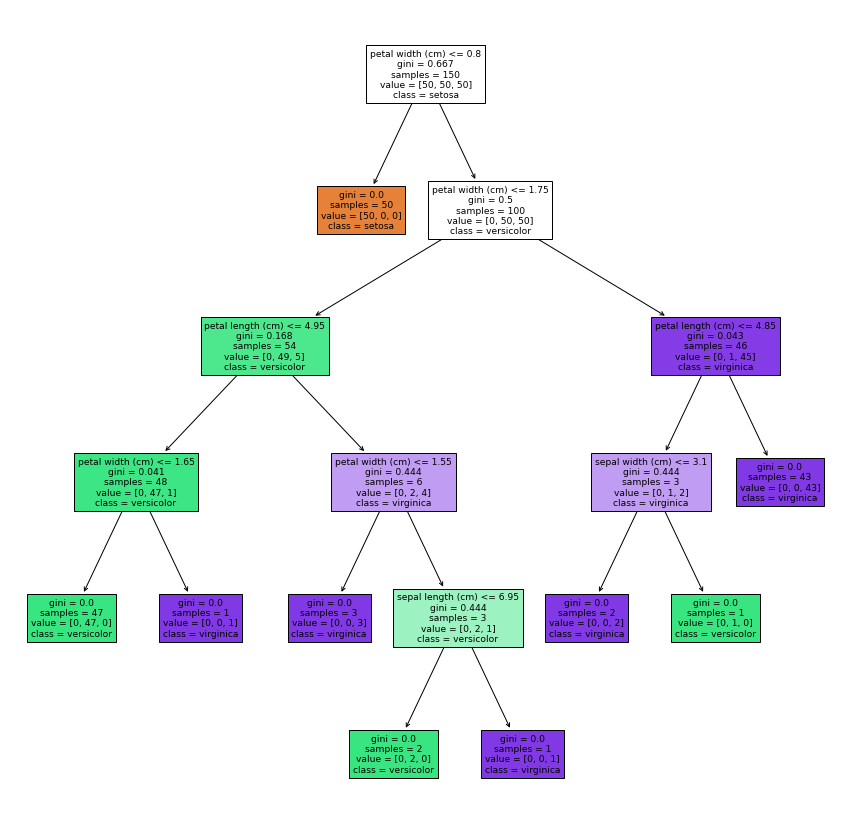

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 15))
plot_tree(decision_tree, feature_names=decision_tree.feature_names_in_,
          class_names=iris.target_names, filled=True)
plt.show()

The default splitting criterion is not entropy-based (as in the lecture), but uses the [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), which you can also see in the plot.
(You can try setting `criterion="entropy"` when creating the tree object if you like.)
In all leaf nodes, this impurity is reduced to zero, i.e., classes are separated perfectly.
The `value` fields in the nodes tell us how many data objects belong to each of the three classes.

If you compare the tree with the solution to sub-task e) of exercise sheet 1, the splits make sense.
For example, the first split, `petal width (cm) <= 0.8` is in the middle between the maximum for `setosa` and the minimum of `versicolor`.
The second split, `petal width (cm) <= 1.75` is roughly in the middle between `versicolor` and `virginica`.
As the latter two distributions overlap slightly, further splits are necessary to create pure partitions.
However, Gini impurity does not change much further down in the tree.
You can use the hyperparameter `min_impurity_decrease` to stop splitting earlier.

By the way, there also is a function to create a textual representation of the tree:

In [8]:
from sklearn.tree import export_text

print(export_text(decision_tree, feature_names=list(decision_tree.feature_names_in_)))

|--- petal width (cm) <= 0.80
|   |--- class: setosa
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- petal width (cm) <= 1.65
|   |   |   |   |--- class: versicolor
|   |   |   |--- petal width (cm) >  1.65
|   |   |   |   |--- class: virginica
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: virginica
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- sepal length (cm) <= 6.95
|   |   |   |   |   |--- class: versicolor
|   |   |   |   |--- sepal length (cm) >  6.95
|   |   |   |   |   |--- class: virginica
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |--- class: virginica
|   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |--- class: versicolor
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: virginica



## c) Evaluation

For cross-validation, we need to write a few more lines of code than before, but it still is easy (and can be nicely re-used for other classification problems):

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

k = 10
model = DecisionTreeClassifier(random_state=25)
X = iris_df.drop(columns='species')
y = iris_df['species']
splitter = StratifiedKFold(n_splits=k, random_state=25, shuffle=True)
train_performances = []
test_performances = []
for train_idx, test_idx in splitter.split(X=X, y=y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X=X_train, y=y_train)
    y_train_pred = model.predict(X=X_train)
    y_test_pred = model.predict(X=X_test)
    train_performances.append(accuracy_score(y_true=y_train, y_pred=y_train_pred))
    test_performances.append(accuracy_score(y_true=y_test, y_pred=y_test_pred))
performances = pd.DataFrame(data={'Train': train_performances, 'Test': test_performances})

The `StratifiedKFold` object provides a splitting method, which returns indices to subset the data into training and test.
(Formally, it does not return a list of pairs/tuples of train and test indices, but a [generator](https://www.programiz.com/python-programming/generator).
However, that is not really relevant for us, we can just iterate over it like over a list.)

We use a stratified split to make sure the class frequencies are the same in training and test.
If the dataset is large enough and we sample randomly, training and test splits should naturally have very similar distributions.
Note that we also use the `shuffle` option to avoid that the split just partitions the data objects according to their given order.
Quite often, data are sorted in some manner, which would cause training and test splits to differ in their distributions.
For example, the `iris` data are sorted by class (though we already fight that with stratification):

In [10]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Okay, enough theory, let's have a look at the actual performances of our decision tree in cross-validation:

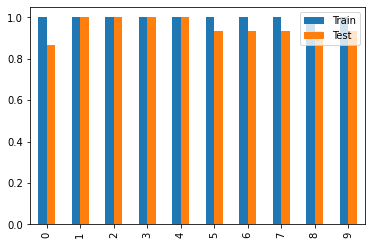

,Train,Test
count,10.0,10.00
mean,1.0,0.95
std,0.0,0.04
min,1.0,0.87
25%,1.0,0.93
50%,1.0,0.93
75%,1.0,1.00
max,1.0,1.00


In [11]:
performances.plot.bar()
plt.show()
performances.describe().round(2)

As mentioned above, decision trees trained without any restrictions are prone to overfitting.
Here, the model reaches perfect training accuracy on each fold.
Average test accuracy is not perfect, but very high as well.
Given the easy separability of the classes, this is no surprise.
Test accuracy shows some variance between folds.
As the dataset only contains 150 data objects, test folds are quite small in 10-fold cross-validation:
They only contain 15 data objects each.
However, if we average over folds in the end anyway, this should not be a problem.
In general, there is no best `k`.
Runtime might play a role, because a higher `k` implies more computational effort.
5 and 10 are typical values for `k`.
[Here](https://stats.stackexchange.com/questions/154830/10-fold-cross-validation-vs-leave-one-out-cross-validation) and [here](https://stats.stackexchange.com/questions/61783/bias-and-variance-in-leave-one-out-vs-k-fold-cross-validation/244112) are two interesting StackExchange posts discussing the choice of `k`.

## d) Baseline

As you might remember from the first exercise sheet, all three classes in the `iris` dataset occur with equal frequency:

In [12]:
y.value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

This naturally yields a baseline accuracy of $\frac{1}{3}$ for guessing the most common class.
Let's implement and evaluate such a "classifier" manually.
Note that we use the full dataset for training and evaluation here.
If data splits are stratified regarding the class anyway, we don't really need cross-validation for this particular baseline.

In [13]:
guessed_class = y.mode()[0]
prediction = pd.Series([guessed_class] * len(iris_df))
print('Accuracy:', round((prediction == y).mean(), 2))

Accuracy: 0.33


As there can be multiple most common classes (= modes) in case of ties, we just pick the first one.
Next, we simply duplicate it to get a constant prediction.
(Python allows you to multiply lists with integers to concatenate repetitions of the list.)

So why did we compute this baseline performance?
Well, any proper prediction model should beat this baseline consistently.
If a prediction model is significantly worse, something might be wrong with its configuration (e.g., data format).
If a prediction model performs similar to the baseline, it might also just guess the most common class, without learning anything useful from the features in `X`.

Instead of doing the steps above manually, we can use a classifier from `sklearn`:

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X=X, y=y)
print('Accuracy:', round(dummy_clf.score(X=X, y=y), 2))

Accuracy: 0.33


Note how we use the method `score()` this time, instead of manual computation as directly above and instead of `fit()` and `accuacy_score()` as in c).

## e) Hyperparameter Tuning

To learn trees of different complexity, we control the tree depth.
As in sub-task c), we use 10-fold cross-validation for evaluation.

In [15]:
k = 10
splitter = StratifiedKFold(n_splits=k, random_state=25, shuffle=True)
performances = []
for fold_idx, (train_idx, test_idx) in enumerate(splitter.split(X=X, y=y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    for max_depth in range(1, 11):
        model = DecisionTreeClassifier(random_state=25, max_depth=max_depth)
        model.fit(X=X_train, y=y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_performance = accuracy_score(y_true=y_train, y_pred=y_train_pred)
        test_performance = accuracy_score(y_true=y_test, y_pred=y_test_pred)
        performances.append({'Fold': fold_idx, 'max_depth': max_depth,
                             'Train': train_performance, 'Test': test_performance})
performances = pd.DataFrame(data=performances)

Let's plot summarize and plot the results:

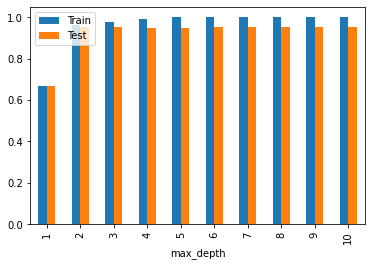

,Train,Test
max_depth,,
1,0.67,0.67
2,0.96,0.95
3,0.98,0.95
4,0.99,0.95
5,1.00,0.95
6,1.00,0.95
7,1.00,0.95
8,1.00,0.95
9,1.00,0.95


In [16]:
plot_data = performances.groupby('max_depth').mean().drop(columns='Fold')  # aggregate over folds
plot_data.plot.bar()
plt.show()
plot_data.round(2)

As we already saw, one split is sufficient to separate one class from the other two.
The second split separates the remaining two classes quite good.
So, if your goal is to have a model which is easy to comprehend for humans and has a high accuracy, you can choose `max_depth=2` here.
(By the way, ["Explainable AI" (XAI)](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) is a hot research topic at the moment.)
If you don't mind a larger model and if you consider the fast training time on our small dataset, simply training a tree of unlimited depth is fine as well.
In particular, overfitting does not hurt test-set performance here.
As we found out above, actual tree depth does not go beyond five, since that depth is sufficient to create pure partitions.

There are various algorithms for hyperparameter tuning.
`sklearn` itself contains multiple approaches, e.g., random search (`sklearn.model_selection.GridSearchCV`) and grid search (`sklearn.model_selection.RandomizedSearchCV`).
In grid search, one has a set of values for each hyperparameter and evaluates the cross-product of them.
In that sense, we conducted a one-dimensional grid search here.